In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import statsmodels.api as sm
import numpy as np
from scipy import stats

## 1️⃣ Importing data.csv

In [2]:
data = pd.read_csv("housing.csv")
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


## 2️⃣ Check for null values and types

In [3]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RM       489 non-null    float64
 1   LSTAT    489 non-null    float64
 2   PTRATIO  489 non-null    float64
 3   MEDV     489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB
None
RM         0
LSTAT      0
PTRATIO    0
MEDV       0
dtype: int64


## ✅ Great! The dataset has no missing values

## 3️⃣ A bit of pre-processing

In [4]:
# Handling Missing Values (no missing values here, so this is just for completeness)
data.fillna(data.mean(), inplace=True) 

# Standardize all features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

scaled_data.head()

,RM,LSTAT,PTRATIO,MEDV
0,0.520554,-1.125077,-1.525083,0.300640
1,0.281048,-0.537070,-0.339748,-0.004498
2,1.469245,-1.259357,-0.339748,1.661047
3,1.178417,-1.413427,0.086973,1.495764
4,1.410146,-1.075605,0.086973,1.851759


## 4️⃣Exploring our data

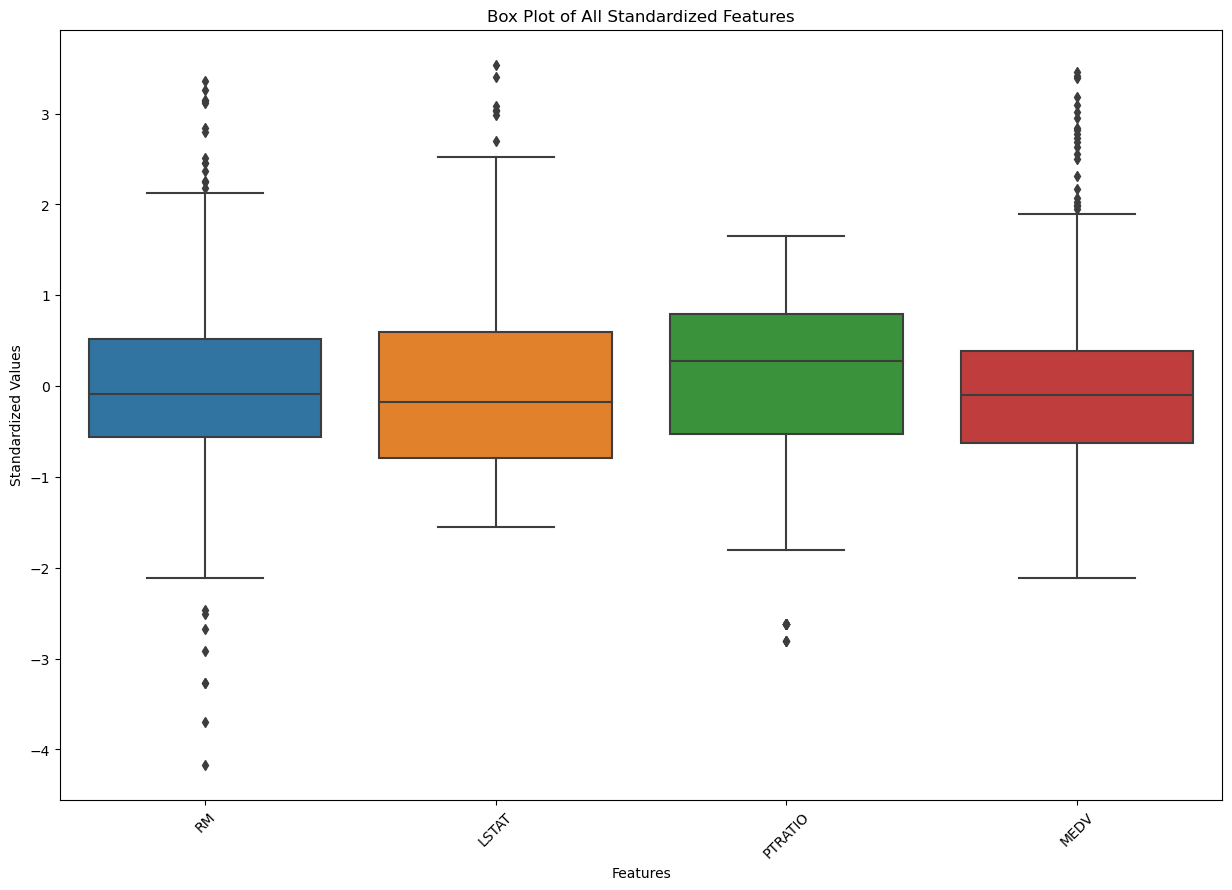

C:\Users\asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


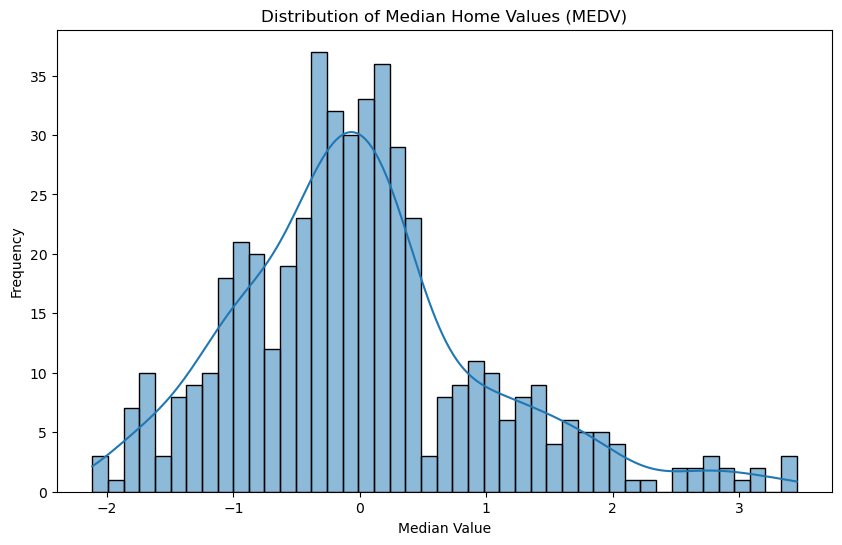

In [5]:
# Box plot for each feature to detect outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=scaled_data)
plt.title('Box Plot of All Standardized Features')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.xticks(rotation=45)
plt.show()

# Checking the distribution of our target (Median Value in $)
plt.figure(figsize=(10, 6))
sns.histplot(scaled_data['MEDV'], bins=45, kde=True)
plt.title('Distribution of Median Home Values (MEDV)')
plt.xlabel('Median Value')
plt.ylabel('Frequency')
plt.show()

## 5️⃣ Train Test Split 

In [6]:
X = scaled_data[['RM', 'LSTAT']] 
y = scaled_data['MEDV']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=100)

## 6️⃣ OLS Regression Results on Training Data (For later comparaison)

In [7]:
%%time
# Add a constant for statsmodels to calculate p-values and diagnostics
X_train_sm = sm.add_constant(X_train)

# Fit the model using statsmodels to calculate p-values and coefficients
model_sm = sm.OLS(y_train, X_train_sm).fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     390.0
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           8.96e-96
Time:                        21:29:41   Log-Likelihood:                -355.39
No. Observations:                 415   AIC:                             716.8
Df Residuals:                     412   BIC:                             728.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.028     -0.173      0.8

## 7️⃣ Fit the linear regression model & Predict
> Normally, the sklearn LinearRegression model is OLS based

In [8]:
# Also fit a regular Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
%%time
# Make predictions on the test set
y_pred = model.predict(X_test)

CPU times: total: 0 ns
Wall time: 1 ms


## 8️⃣ Model Evaluation Results

In [10]:
# Evaluate the model using MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.40
R-squared: 0.70


- An MSE of 0.66 seems acceptable, but the scale of this value depends on how the target variable (MEDV) was transformed.
- But that's totally normall since we're only relying on 1 feature, adding more features would improve it :)

## 9️⃣ Visualizing the Regression Line

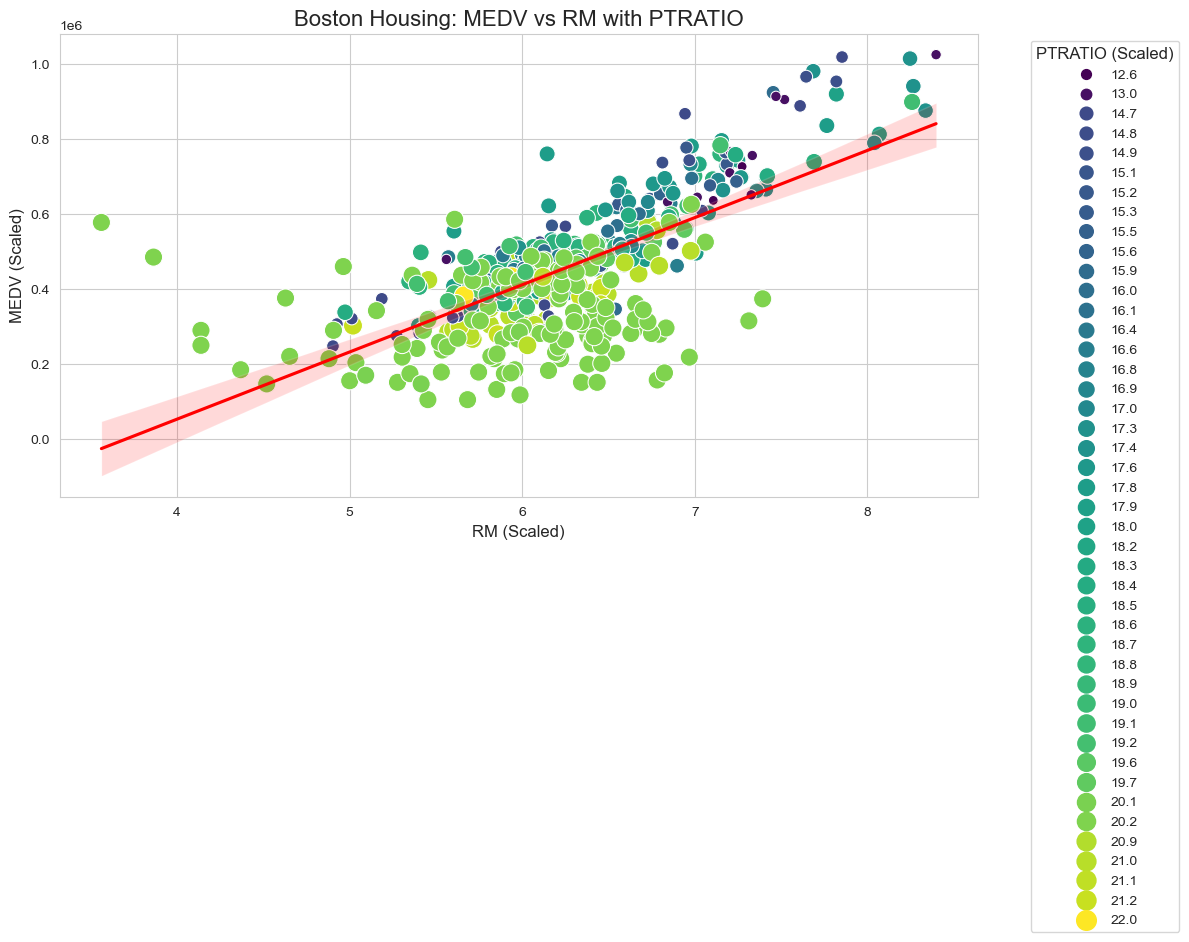

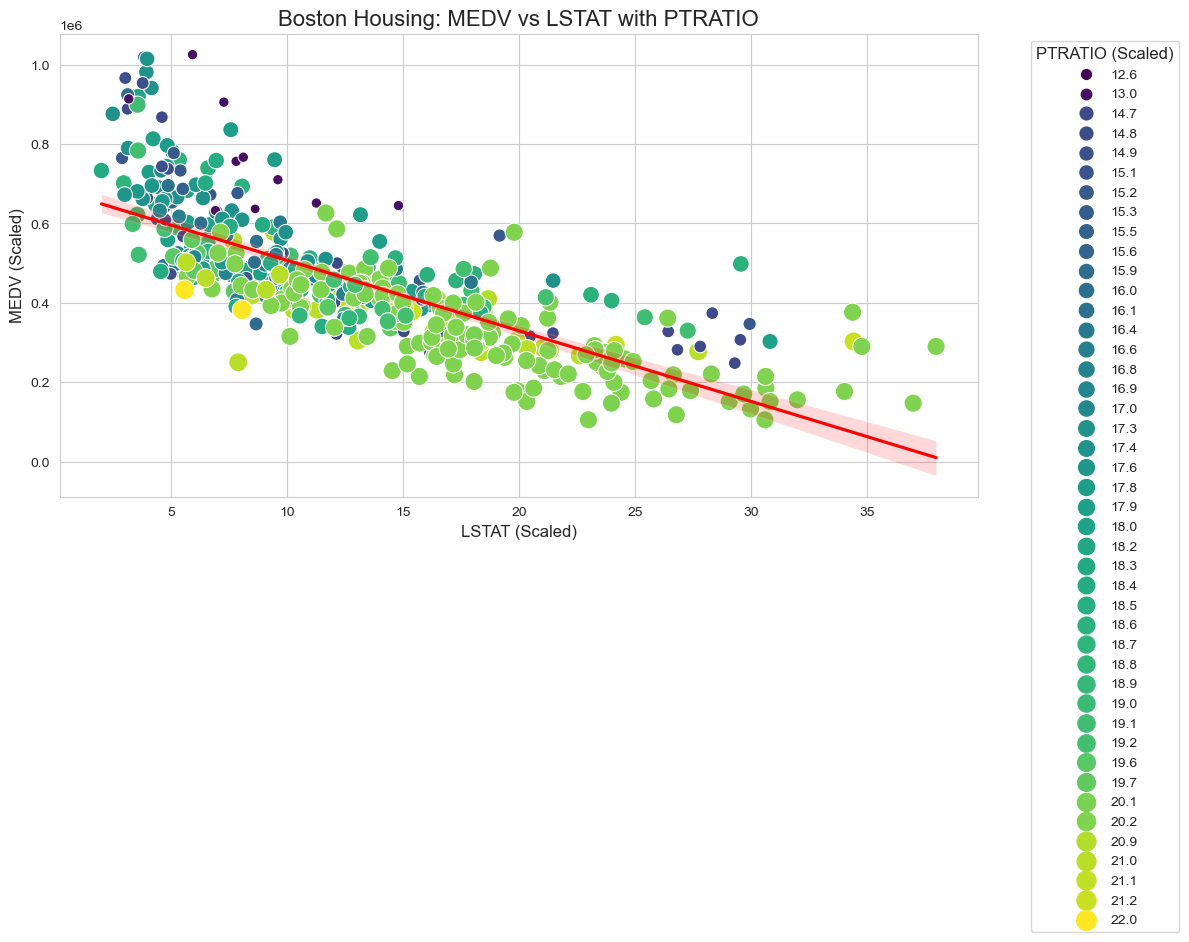

In [23]:
def create_regression_plot(data, x_feature, y_feature='MEDV', size_feature='PTRATIO'):
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    # Create the scatter plot
    scatter = sns.scatterplot(data=data, x=x_feature, y=y_feature, hue=size_feature, size=size_feature, 
                              palette='viridis', sizes=(50, 200), legend='full')

    # Fit the regression line
    X = data[[x_feature]]
    y = data[y_feature]
    reg = LinearRegression().fit(X, y)

    # Plot the regression line
    sns.regplot(x=x_feature, y=y_feature, data=data, scatter=False, color='r')

    # Customize the plot
    plt.title(f'Boston Housing: {y_feature} vs {x_feature} with {size_feature}', fontsize=16)
    plt.xlabel(f'{x_feature} (Scaled)', fontsize=12)
    plt.ylabel(f'{y_feature} (Scaled)', fontsize=12)

    # Adjust legend
    plt.legend(title=f'{size_feature} (Scaled)', title_fontsize='12', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Create the two plots
create_regression_plot(data, 'RM')
create_regression_plot(data, 'LSTAT')

## 🔟 Model Diagnostics 

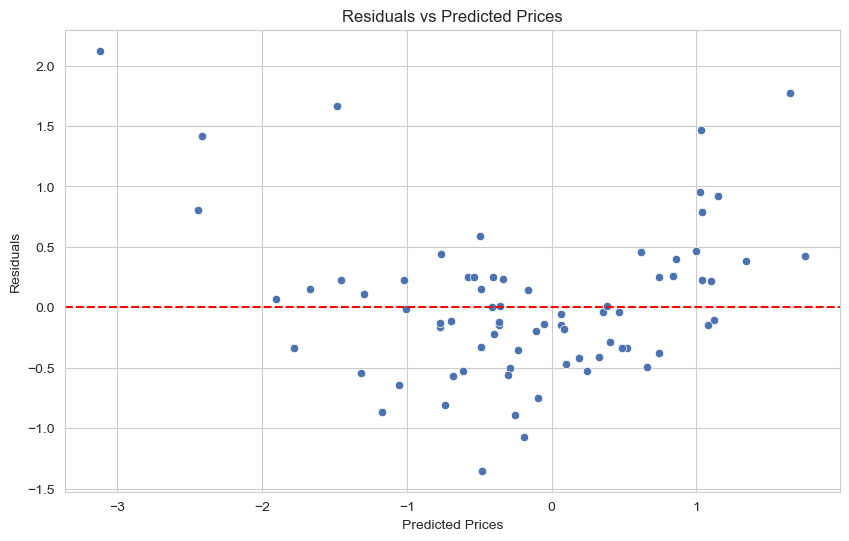

In [24]:
# Residual Analysis: Plot residuals to check for patterns
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Prices')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()

> ⓘ Residuals should be randomly scattered around zero for a good model.

C:\Users\asus\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


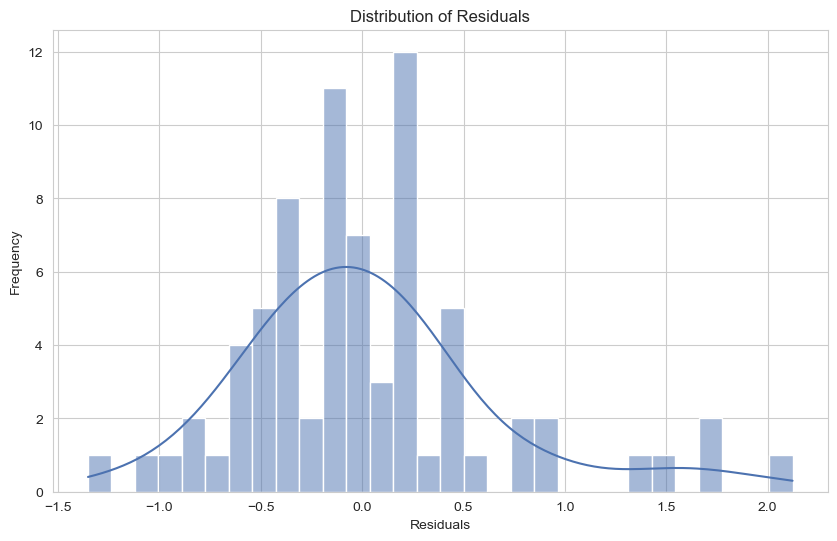

In [25]:
# Check for normality of residuals (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

> ⓘ A normal distribution centered at 0 without Skewing indicates a good model.

In [31]:
# Conducting Normality Test (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test p-value for normality: {shapiro_test.pvalue:.4f}")

Shapiro-Wilk Test p-value for normality: 0.0007


> p_value < 0.05 which indicates a clear statistical significance.

In [27]:
# Test for Homoscedasticity (Breusch-Pagan)
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(residuals, sm.add_constant(X_test))
print(f'Breusch-Pagan test p-value for homoscedasticity: {pval:.4f}')

Breusch-Pagan test p-value for homoscedasticity: 0.1426


> Based on this p-value (0.1426), we fail to reject the null hypothesis of homoscedasticity. This suggests that there is not enough evidence to conclude that heteroscedasticity is present in your model.

In [32]:
# Multicollinearity Check: Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = sm.add_constant(X)  # Include constant for intercept
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

  Feature       VIF
0   const  95.18877
1      RM   1.00000


## ❗ Checking for Overfitting and Underfitting

In [33]:
# Evaluate model performance on training data
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training Set Mean Squared Error: {train_mse:.2f}')
print(f'Training Set R-squared: {train_r2:.2f}')
print(f'Testing Set R Squared: {r2:.2f}')

Training Set Mean Squared Error: 0.32
Training Set R-squared: 0.65
Testing Set R Squared: 0.70


- Both the training and testing sets are relatively close (0.65 and 0.70), suggesting that the model generalizes well to new data. The MSE on the training set is also reasonably low, indicating that the model fits the training data well without capturing too much noise.
- It appears that the model is well-fitted. 

In [34]:
# Save the model to a file
joblib.dump(model, 'linear_regression_model.joblib')

['linear_regression_model.joblib']